In [1]:
import os 
import sys

import numpy as np

from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import re

import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.insert(0, "../porousequivariantnetworks/code/")
sys.path.insert(0, "../porousequivariantnetworks/")

from models.equivariant_mpnn import MPNNPORE

from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [2]:
data = get_zeolite('MOR')

ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
_, _, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l)

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)


In [3]:
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)


In [237]:
def get_ats(idx):
    with open(f'Data_isotherms/isomors/MOR_{idx}.cif') as f:
        lines = f.readlines()
    lines = [i.strip().split() for i in lines]
    lines = [i for i in lines if len(i)>1]


    at_pos = [i[1:5] for i in lines if i[1] in ['Si', 'Al']]
    atom = [1 if i[0]=='Al' else 0 for i in at_pos]
    return atom

def get_iso(idx):
    with open(f'Data_isotherms/curves/plot_data_{idx}') as f:
        lines = f.read()
        #p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?)', lines)
        p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?(?:e[+-]?\d+)?)', lines)

    p = [float(i) for i in p]
    x = 10**np.arange(1,7,0.01)
    true_p = langmuirfreudlich(np.array(p)[None], x)

    return p

def langmuirfreudlich(p, x):
    return p[:,0]*p[:,1]*x**p[:,2]/(1.0+p[:,1]*x**p[:,2])+p[:,3]*p[:,4]*x**p[:,5]/(1.0+p[:,4]*x**p[:,5])
    

In [238]:
n = 989

atoms = np.zeros((n, 48))
iso_params = np.zeros((n, 6))


for zeo in tqdm(range(n)):

    atoms[zeo] = get_ats(zeo)
    iso_params[zeo] = get_iso(zeo)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 989/989 [00:00<00:00, 1465.17it/s]


In [239]:
iso_params[961]

array([2.74420e+00, 3.63862e-03, 5.66549e-01, 9.35182e+00, 8.62976e-13,
       1.50196e+00])

In [240]:
a = langmuirfreudlich(trainloader.dataset.y, torch.tensor(np.tile((10**np.arange(1,8,7/100))[:, None], (1,904)))).T

In [241]:
np.isnan(a).sum()

tensor(0)

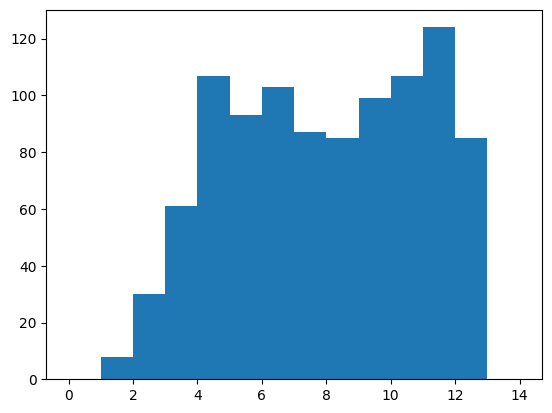

In [242]:
plt.hist(atoms.sum(1), bins=np.arange(0, 15));

In [243]:
def get_pred_points(steps):

    return 10**np.arange(1,7+1/steps,1/steps)
    

In [259]:
class calculate_distance(nn.Module):

    def __init__(self, n_points=100):
        super().__init__()

        self.points = torch.tensor(10**np.arange(1,7+6/n_points,6/n_points))[:, None]
        self.n_points = n_points
        self.relu = nn.ReLU()
        
    def forward(self, param_p_hat, param_p):
        # add channels dimension
        param_p_hat = self.relu(param_p_hat)
        param_p_hat = param_p_hat[:,None]

        
        p_hat = F.interpolate(param_p_hat, self.n_points+1, align_corners=True, mode='linear').squeeze()
        points = self.points.repeat(1, param_p_hat.shape[0]).to('cuda')
        p = langmuirfreudlich(param_p, points).T

        loss = ((p_hat - p)**2).mean(1)
        return loss
        

        
    

In [263]:
pred_points = get_pred_points(10)

In [264]:
len(pred_points)

61

In [265]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                hid_size=[12]*6, site_emb_size=12, edge_emb_size=12, mlp_size=24,
                centers=10, mx_d=6, width=1, pool='sum', 
                out_size=len(pred_points)).to('cuda')

In [266]:
_, testloader, trainloader = get_data_pore(atoms, iso_params, edges, pore, edges_sp, edges_ps, bs=32, sub_lim=12, p=1)

In [ ]:
tr_loss, te_loss = mpnn.fit(trainloader, testloader, epochs=20, crit=calculate_distance, crit_kwargs={'n_points':500}, opt=optim.Adam, opt_kwargs={'lr':0.001}, scale_loss=False)

 65%|███████████████████████████████████████████████████████▎                             | 13/20 [02:15<01:12, 10.40s/epoch, loss: 0.575 test loss: 0.516]

In [ ]:
def plot_true_pred(iso_params, atoms, pred_points, fig=None, ax=None):

    atoms = atoms.cuda().float()
    iso_params = iso_params.numpy()

    if fig is None:
        fig, ax = plt.subplots()

    x = 10**np.arange(1,7.01,0.01)
    true_p = langmuirfreudlich(iso_params, x)
    ax.plot(x, true_p)

    with torch.no_grad():
        mpnn.eval()
        p_hat = mpnn.forward(atoms.repeat(2,1,1), edges.cuda()[None].repeat(2,1,1), torch.tensor(pore).cuda().float()[None].repeat(2,1,1), edges_sp.cuda()[None].repeat(2,1,1), edges_ps.cuda()[None].repeat(2,1,1))[0].cpu()
        p_hat = nn.ReLU()(p_hat)

    ax.plot(pred_points, p_hat)

    ax.set_xscale('log')
    return fig, ax

In [ ]:
plot_true_pred(testloader.dataset.y[[12]], testloader.dataset.X[[12]], pred_points)

In [ ]:
plot_true_pred(testloader.dataset.y[[0]], testloader.dataset.X[[0]], pred_points)

In [ ]:
plot_true_pred(testloader.dataset.y[[1]], testloader.dataset.X[[1]], pred_points)

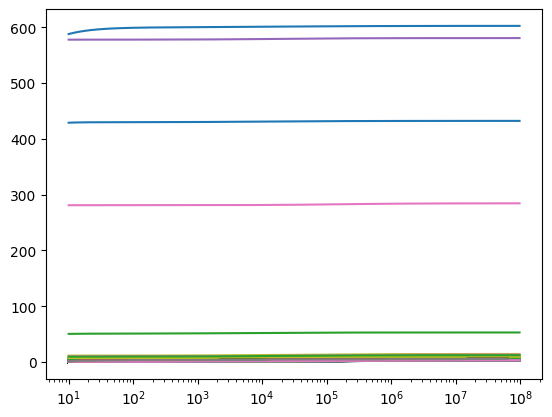

In [217]:
fig, ax = None, None
for i in range(len(trainloader.dataset)):
    fig, ax = plot_true_pred(trainloader.dataset.y[[i]], trainloader.dataset.X[[i]], pred_points, fig, ax)